In [32]:
# ==== TPA Calibration ====
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit

# Function to read MATLAB v7.3 files
def load_matlab_v73(filename):
    """Load MATLAB v7.3 file using h5py"""
    data = {}
    with h5py.File(filename, 'r') as f:
        def extract_data(name, obj):
            if isinstance(obj, h5py.Dataset):
                data[name] = np.array(obj)
        f.visititems(extract_data)
    return data

# Load calibration data
cal_file = "/Volumes/T7Shield/Diamond3D_25May/Calibration/Calibration_ND1_0to400_100KHz_405nm.mat"
cal_data = load_matlab_v73(cal_file)

# Extract data
data_cal = cal_data['data']
power_meter_data = cal_data['power_meter_data']

# Extract charge amp data (channel 2) from structure (50000, 4, 1, 401, 1, 1, 1, 1)
charge_amp_data = data_cal[:, 2, 0, :, 0, 0, 0, 0].T  # Shape: (401, 50000)
max_values = np.max(charge_amp_data, axis=1)  # Max of each waveform

# Extract power meter readings and divide by 100k
power_readings = power_meter_data.flatten() / 100000

# Linear fitting (flipped: x=max_values, y=power_readings)
def linear_func(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear_func, max_values, power_readings * 1e9)
slope, intercept = popt

print(f"Calibration equation: Power(mW) = {slope:.6f} * WaveformMax + {intercept:.6f}")


Calibration equation: Power(mW) = 92.831020 * WaveformMax + -0.603128


Measurement data shape: (40000, 4, 1, 6, 1, 1, 1, 201)
Baseline correction: subtracted 0.000020
Depth conversion: optical → physical (×2.4582)


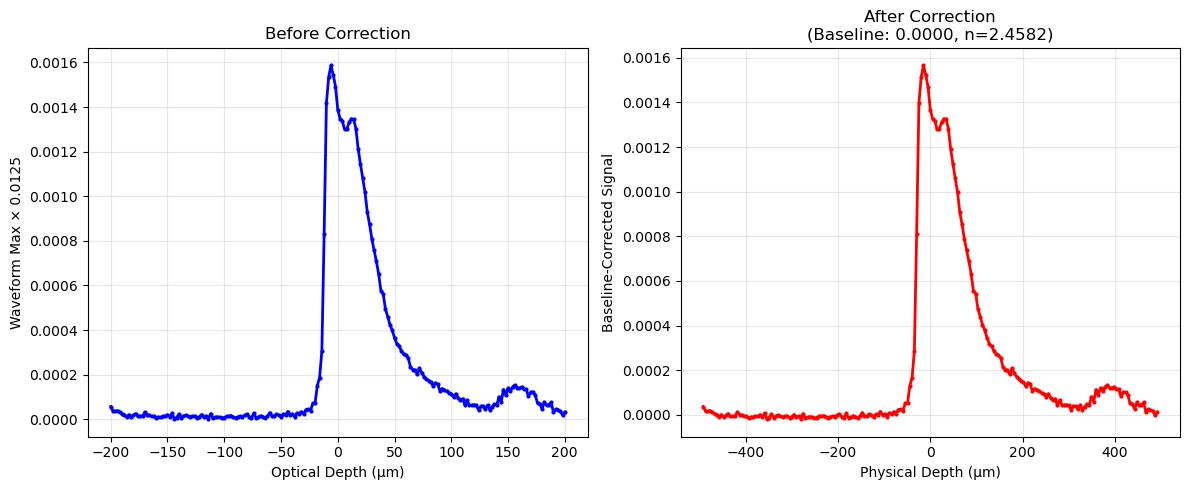

Corrected data: 201 depth points
Physical depth range: -491.6 to 491.6 μm


In [33]:
# ==== Step 2: Measurement Analysis ====
# Load measurement data
meas_file = "/Volumes/T7Shield/Diamond3D_25May/Test5_CxL_ZVEscan_Z-200to200d2_backmiddia/t5b2_ZEscan_+10V_cent_back(+x-y18d75)_50to100d10_newpos.mat"
meas_data = load_matlab_v73(meas_file)

# Extract measurement data
data_meas = meas_data['data']

# Extract z positions (1st parameter) and signal waveforms (7th parameter = channel 1)
# Assuming data structure where 1st dim is z, 7th dim is channel
# Need to find the correct indexing based on the actual data structure

# First, let's check the data structure
print(f"Measurement data shape: {data_meas.shape}")

# Extract signal waveforms: 5th parameter (energy) = 1, 7th parameter (channel) = 1
# Data structure: (40000, 4, 1, 6, 1, 1, 1, 201)
# We want: waveform samples x z_positions for energy=1, channel=1
if data_meas.shape == (40000, 4, 1, 6, 1, 1, 1, 201):
    # Extract: [:, channel=0 (1st), :, energy=0 (1st), :, :, :, z_positions]
    signal_waveforms = data_meas[:, 0, 0, 0, 0, 0, 0, :]  # Shape: (40000, 201)
    
    # Calculate max of each z-position's waveform and multiply by 0.0125
    waveform_max = np.max(signal_waveforms, axis=0) * 0.0125  # Max along waveform dimension
    
    # Z positions: 201 points from -200 to +200 with step 2
    z_positions = np.linspace(-200, 200, data_meas.shape[-1])

else:
    # Fallback for other data structures
    if len(data_meas.shape) >= 7:
        # Extract with energy=1 (index 0) and channel=1 (index 0)
        signal_waveforms = data_meas[:, 0, :, 0, :, :, 0, :]  # Energy=1, Channel=1
        
        # Calculate max of each waveform and multiply by 0.0125
        waveform_max = np.max(signal_waveforms, axis=0) * 0.0125
        
        # Generate z positions
        z_positions = np.arange(waveform_max.shape[-1]) * 2 - 200
        waveform_max = waveform_max.flatten()
    else:
        # Simple fallback
        waveform_max = np.max(data_meas, axis=0) * 0.0125
        z_positions = np.arange(len(waveform_max)) * 2 - 200



# Ensure z_positions and waveform_max have the same length
min_len = min(len(z_positions), len(waveform_max.flatten()))
z_positions = z_positions[:min_len]
waveform_max = waveform_max.flatten()[:min_len]

# ==== Apply corrections ====
# 1. Baseline correction - subtract the median of the first 10% of data points as baseline
baseline_points = int(0.1 * len(waveform_max))
baseline = np.median(waveform_max[:baseline_points])
waveform_max_corrected = waveform_max - baseline

# 2. Convert optical depth to physical depth by multiplying by refractive index
n_diamond = 2.4582
z_positions_physical = z_positions * n_diamond

print(f"Baseline correction: subtracted {baseline:.6f}")
print(f"Depth conversion: optical → physical (×{n_diamond})")

# Plot corrected data
plt.figure(figsize=(12, 5))

# Left: Before correction
plt.subplot(1, 2, 1)
plt.plot(z_positions, waveform_max, 'b.-', linewidth=2, markersize=4)
plt.xlabel('Optical Depth (μm)')
plt.ylabel('Waveform Max × 0.0125')
plt.title('Before Correction')
plt.grid(True, alpha=0.3)

# Right: After correction
plt.subplot(1, 2, 2)
plt.plot(z_positions_physical, waveform_max_corrected, 'r.-', linewidth=2, markersize=4)
plt.xlabel('Physical Depth (μm)')
plt.ylabel('Baseline-Corrected Signal')
plt.title(f'After Correction\n(Baseline: {baseline:.4f}, n={n_diamond})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Corrected data: {len(z_positions_physical)} depth points")
print(f"Physical depth range: {z_positions_physical[0]:.1f} to {z_positions_physical[-1]:.1f} μm")

# Update variables for use in fitting
z_positions = z_positions_physical
waveform_max = waveform_max_corrected


Pre-calculating TPA lookup table for focus positions -600 to +600 μm...
Lookup table ready!
Maximum signal at position: -14.7 μm
Fitting 18 data points from -100 to max position
Z range: -98.3 to -14.7 μm
Signal range: -0.000009 to 0.001566
Constraining amplitude < 3.52e-12 to keep fitted curve max < 0.0017
Initial x_offset guess: -14.7 μm
Fitted curve maximum: 0.001568 (target: < 0.0017)

TPA Model Fit Results:
NAv (effective NA): 0.3305
Amplitude: 1.37e-12
X-offset: -29.38 μm
R-squared: 0.9989


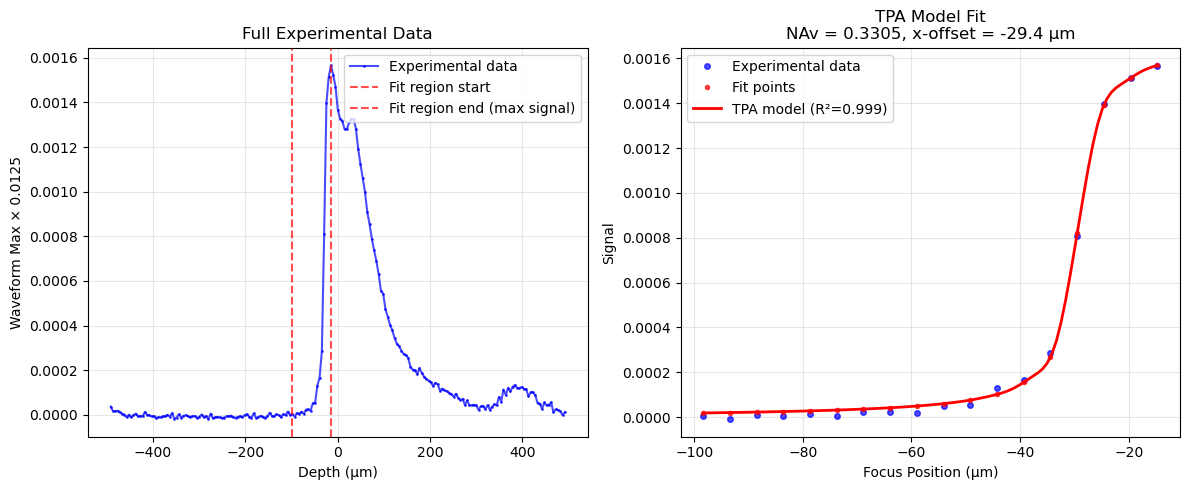

In [34]:
# ==== Step 3: Fit TPA Model to Experimental Data ====
from scipy.optimize import curve_fit

# Physical constants
c = 299792458  # Speed of light in m/s
hbar = 1.0545718e-34  # Reduced Planck constant in J⋅s

def calculate_total_charge_vs_hcenter(h_centers, MAv, 
                                     wavelength=405e-9, nr=2.4582, Epulse=1e-9, 
                                     dcf=0.0, R=0.0, Q=18000,
                                     r_range=(0, 20e-6, 200),
                                     z_range=(0, 500e-6, 500)):
    """
    Calculate total charge in detector (0-500μm) as function of H center position
    MAv is the fitting parameter (effective NA)
    """
    
    # Constants
    tpalength = wavelength
    tpatau = 160e-15
    b = 1.5e-11
    f = c/tpalength
    
    # Calculate step sizes  
    dr = (r_range[1] - r_range[0]) / r_range[2]
    dz = (z_range[1] - z_range[0]) / z_range[2]
    
    # Create coordinate grids
    r = np.linspace(r_range[0] + dr/2, r_range[1] - dr/2, r_range[2])
    z = np.linspace(z_range[0] + dz/2, z_range[1] - dz/2, z_range[2])
    
    # Pre-calculate constants
    tpa_coeff = (2*np.sqrt(np.log(4)))/(2*np.pi**3.5) * (Epulse**2*b/(tpatau*hbar*f))
    waist0_sq = (tpalength/(np.pi*MAv))**2  # Use MAv as fitting parameter
    na_over_n = MAv/nr
    
    total_charges = []
    
    # For each H center, calculate total charge in detector
    for h_center in h_centers:
        
        # Calculate TPA for all z,r positions for this H center
        total_charge = 0.0
        
        for i, z_val in enumerate(z):
            # Calculate waist (relative to focus position h_center)
            waist1_sq = waist0_sq + (na_over_n * (z_val - h_center))**2
            waist2_sq = waist0_sq + (na_over_n * (z_val + h_center))**2
            
            # TPA calculation for all r at this z
            # Primary beam
            ntpa_row = tpa_coeff * (1/waist1_sq**2) * np.exp(-4*r**2/waist1_sq)
            
            # Reflection beam  
            nref_row = tpa_coeff * (1/waist2_sq**2) * np.exp(-4*r**2/waist2_sq) * R**2
            
            # Interference term
            nint_row = np.sqrt(ntpa_row * (tpa_coeff * (1/waist2_sq**2) * np.exp(-4*r**2/waist2_sq))) * dcf * 2 * R
            
            # Total rate for this z slice
            nsum_row = ntpa_row + nref_row + nint_row
            
            # Convert to charge and integrate over r (cylindrical coordinates)
            ndia_row = nsum_row * 2 * np.pi * r
            slice_charge = np.sum(ndia_row) * dr * dz
            total_charge += slice_charge
        
        total_charges.append(total_charge)
    
    return np.array(total_charges)

# Pre-calculate lookup table for fast fitting
# Focus position range: -600 to +600 μm
# Note: Data left-to-right goes INTO diamond from top surface
_lookup_h_positions = np.linspace(-600e-6, 600e-6, 301)  # -600 to +600 μm in meters
_lookup_NAv_values = np.linspace(0.1, 2.0, 20)  # Range of NAv values to pre-calculate

print("Pre-calculating TPA lookup table for focus positions -600 to +600 μm...")
_lookup_table = {}
for NAv in _lookup_NAv_values:
    charges = calculate_total_charge_vs_hcenter(_lookup_h_positions, NAv)
    _lookup_table[NAv] = charges
print("Lookup table ready!")

# Fast interpolation-based TPA model
from scipy.interpolate import interp1d

def tpa_model_fast(h_positions, NAv_fit, amplitude, x_offset):
    """
    Fast TPA model using pre-calculated lookup table with interpolation
    """
    # Apply x-offset (no coordinate flip - let x_offset handle the mapping)
    h_positions_shifted = h_positions - x_offset
    h_centers_m = h_positions_shifted * 1e-6  # Convert to meters
    
    # Find the two closest NAv values in lookup table
    NAv_array = np.array(list(_lookup_table.keys()))
    NAv_fit_clamped = np.clip(NAv_fit, NAv_array.min(), NAv_array.max())
    
    # Find closest NAv values for interpolation
    idx = np.searchsorted(NAv_array, NAv_fit_clamped)
    
    if idx == 0:
        # Use first entry
        charges = _lookup_table[NAv_array[0]]
    elif idx >= len(NAv_array):
        # Use last entry
        charges = _lookup_table[NAv_array[-1]]
    else:
        # Interpolate between two closest NAv values
        NAv_low = NAv_array[idx-1]
        NAv_high = NAv_array[idx]
        weight = (NAv_fit_clamped - NAv_low) / (NAv_high - NAv_low)
        
        charges_low = _lookup_table[NAv_low]
        charges_high = _lookup_table[NAv_high]
        charges = charges_low * (1 - weight) + charges_high * weight
    
    # Interpolate TPA charges at requested h_positions
    tpa_interp = interp1d(_lookup_h_positions, charges, 
                         kind='cubic', bounds_error=False, fill_value=0)
    
    interpolated_charges = tpa_interp(h_centers_m)
    
    # Apply amplitude scaling
    return amplitude * interpolated_charges

# Extract data for fitting
# Data interpretation: left-to-right goes INTO diamond from top surface
# Fit only the data from -100 μm to the position of maximum signal

# Find position of maximum signal
max_signal_idx = np.argmax(waveform_max)
max_position = z_positions[max_signal_idx]

# Create fitting mask: from -100 to max position
fitting_mask = (z_positions >= -100) & (z_positions <= max_position)
z_fit = z_positions[fitting_mask]
signal_fit = waveform_max[fitting_mask]

print(f"Maximum signal at position: {max_position:.1f} μm")
print(f"Fitting {len(z_fit)} data points from -100 to max position")
print(f"Z range: {z_fit.min():.1f} to {z_fit.max():.1f} μm")
print(f"Signal range: {signal_fit.min():.6f} to {signal_fit.max():.6f}")

# Initial parameter guess
# Data max at -14.7 μm, need large x_offset to map to lookup table range
# Try initial offset that maps data max to middle of lookup table (around 0)
initial_x_offset = -14.7  # This would map data max (-14.7) to lookup position 0
initial_guess = [0.5, 1e-15, initial_x_offset]  # NAv, amplitude, x_offset

try:
    # Use fast model for fitting - much faster than full TPA calculation
    # Estimate maximum TPA value to constrain amplitude properly using fast model
    max_tpa_estimate = np.max(tpa_model_fast(np.array([0]), 1.0, 1.0, 0))  # NAv=1.0, amp=1.0, offset=0
    max_amplitude_allowed = 0.0017 / max_tpa_estimate if max_tpa_estimate > 0 else 1.0
    
    print(f"Constraining amplitude < {max_amplitude_allowed:.2e} to keep fitted curve max < 0.0017")
    print(f"Initial x_offset guess: {initial_x_offset:.1f} μm")
    
    # Perform fitting with fast model and expanded x_offset bounds
    # Bounds: NAv (0.1 to 2.0), amplitude (positive), x_offset (much wider range)
    popt_tpa, pcov_tpa = curve_fit(tpa_model_fast, z_fit, signal_fit, 
                                   p0=initial_guess, 
                                   bounds=([0.1, 0, -800], [2.0, max_amplitude_allowed, 800]),
                                   maxfev=2000)
    
    NAv_fitted, amplitude_fitted, x_offset_fitted = popt_tpa
    
    # Check that fitted curve maximum is indeed < 0.0017
    fitted_curve_full = tpa_model_fast(z_fit, *popt_tpa)
    fitted_curve_max = np.max(fitted_curve_full)
    
    print(f"Fitted curve maximum: {fitted_curve_max:.6f} (target: < 0.0017)")
    
    # Calculate fit quality
    y_fit_tpa = tpa_model_fast(z_fit, *popt_tpa)
    ss_res = np.sum((signal_fit - y_fit_tpa)**2)
    ss_tot = np.sum((signal_fit - np.mean(signal_fit))**2)
    r_squared_tpa = 1 - (ss_res / ss_tot)
    
    print(f"\nTPA Model Fit Results:")
    print(f"NAv (effective NA): {NAv_fitted:.4f}")
    print(f"Amplitude: {amplitude_fitted:.2e}")
    print(f"X-offset: {x_offset_fitted:.2f} μm")
    print(f"R-squared: {r_squared_tpa:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Left plot: full experimental data
    plt.subplot(1, 2, 1)
    plt.plot(z_positions, waveform_max, 'b.-', alpha=0.7, markersize=2, label='Experimental data')
    plt.axvline(-100, color='r', linestyle='--', alpha=0.7, label='Fit region start')
    plt.axvline(max_position, color='r', linestyle='--', alpha=0.7, label='Fit region end (max signal)')
    plt.xlabel('Depth (μm)')
    plt.ylabel('Waveform Max × 0.0125')
    plt.title('Full Experimental Data')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Right plot: fit region with TPA model
    plt.subplot(1, 2, 2)
    plt.plot(z_fit, signal_fit, 'bo', alpha=0.7, markersize=4, label='Experimental data')
    
    # Create smooth curve for plotting
    z_smooth = np.linspace(z_fit.min(), z_fit.max(), 100)
    y_smooth = tpa_model_fast(z_smooth, *popt_tpa)
    
    plt.plot(z_fit, y_fit_tpa, 'r.', alpha=0.7, markersize=6, label='Fit points')
    plt.plot(z_smooth, y_smooth, 'r-', linewidth=2, label=f'TPA model (R²={r_squared_tpa:.3f})')
    plt.xlabel('Focus Position (μm)')
    plt.ylabel('Signal')
    plt.title(f'TPA Model Fit\nNAv = {NAv_fitted:.4f}, x-offset = {x_offset_fitted:.1f} μm')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Fitting failed: {e}")
    print("Try adjusting initial parameters or fit region")
